In [2]:
import pandas as pd

df = pd.read_csv("data/FY_2025_Hospital_Readmissions_Reduction_Program_Hospital.csv")

print("Shape of data:", df.shape)
df.head()


Shape of data: (18510, 12)


,Facility Name,Facility ID,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date
0,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-AMI-HRRP,296.0,NaN,0.9483,13.0146,13.7235,36,07/01/2020,06/30/2023
1,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-CABG-HRRP,151.0,NaN,0.9509,9.6899,10.1898,13,07/01/2020,06/30/2023
2,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-HF-HRRP,681.0,NaN,1.0597,21.5645,20.3495,151,07/01/2020,06/30/2023
3,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-HIP-KNEE-HRRP,NaN,NaN,0.9654,4.2680,4.4211,Too Few to Report,07/01/2020,06/30/2023
4,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-PN-HRRP,490.0,NaN,0.9715,16.1137,16.5863,77,07/01/2020,06/30/2023


In [ ]:
# Check missing values
df.isna().sum()


51

In [5]:
df_clean = df.dropna(subset=[
    'Excess Readmission Ratio',
    'Predicted Readmission Rate',
    'Expected Readmission Rate',
    'Number of Discharges'
])
print("Remaining rows:", len(df_clean))


Remaining rows: 8121


In [11]:
df_clean.dtypes


Facility Name                         object
Facility ID                            int64
State                                 object
Measure Name                          object
Number of Discharges                 float64
Excess Readmission Ratio             float64
Predicted Readmission Rate           float64
Expected Readmission Rate            float64
Number of Readmissions                 int64
Start Date                    datetime64[ns]
End Date                      datetime64[ns]
dtype: object

In [10]:
import numpy as np

df_clean['Number of Readmissions'] = (
    df_clean['Number of Readmissions']
    .astype(str)
    .str.replace(',', '', regex=True)
    .replace('Not Available', np.nan)
)
df_clean['Number of Readmissions'] = pd.to_numeric(df_clean['Number of Readmissions'], errors='coerce')

df_clean['Start Date'] = pd.to_datetime(df_clean['Start Date'], errors='coerce')
df_clean['End Date'] = pd.to_datetime(df_clean['End Date'], errors='coerce')

In [ ]:
df_model = df_clean[['Facility ID', 'State', 'Measure Name',
                     'Number of Discharges',
                     'Predicted Readmission Rate',
                     'Expected Readmission Rate',
                     'Excess Readmission Ratio']]

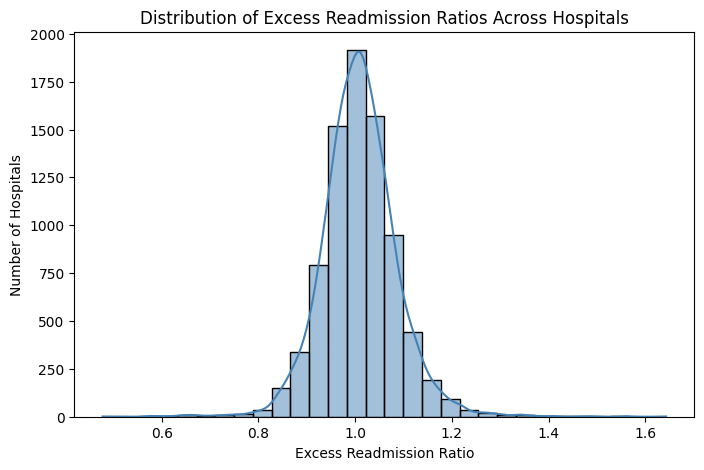

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(df_clean['Excess Readmission Ratio'], bins=30, kde=True, color='steelblue')
plt.title('Distribution of Excess Readmission Ratios Across Hospitals')
plt.xlabel('Excess Readmission Ratio')
plt.ylabel('Number of Hospitals')
plt.show()

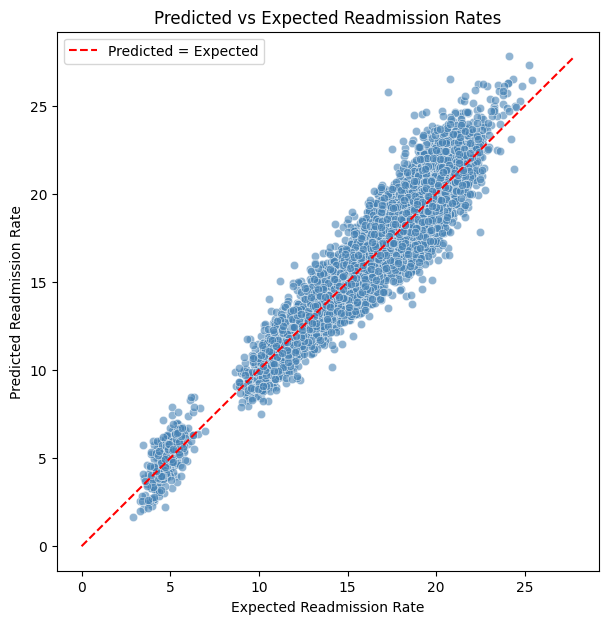

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,7))

sns.scatterplot(
    x='Expected Readmission Rate',
    y='Predicted Readmission Rate',
    data=df_clean,
    alpha=0.6,
    color='steelblue'
)

# Add diagonal reference line (Predicted = Expected)
max_val = max(df_clean['Predicted Readmission Rate'].max(),
              df_clean['Expected Readmission Rate'].max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Predicted = Expected')

plt.title('Predicted vs Expected Readmission Rates')
plt.xlabel('Expected Readmission Rate')
plt.ylabel('Predicted Readmission Rate')
plt.legend()
plt.show()


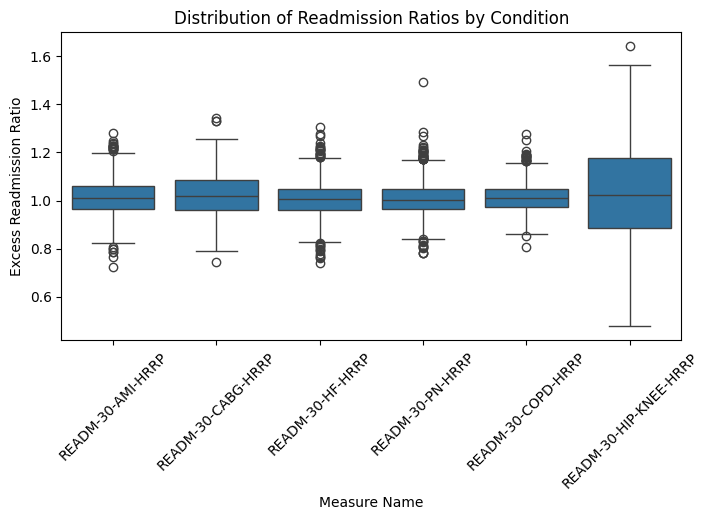

In [27]:
plt.figure(figsize=(8,4))
sns.boxplot(data=df_clean, x='Measure Name', y='Excess Readmission Ratio')
plt.title('Distribution of Readmission Ratios by Condition')
plt.xticks(rotation=45)
plt.show()


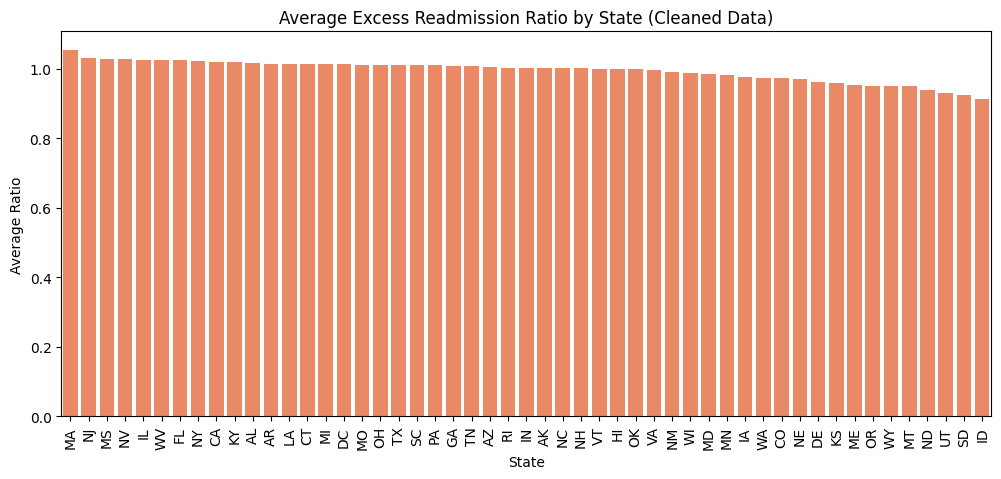

In [28]:
state_avg = df_clean.groupby('State')['Excess Readmission Ratio'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,5))
sns.barplot(x=state_avg.index, y=state_avg.values, color='coral')
plt.xticks(rotation=90)
plt.title('Average Excess Readmission Ratio by State (Cleaned Data)')
plt.ylabel('Average Ratio')
plt.show()


In [29]:
# Average Excess Readmission Ratio by State
avg_ratio_by_state = (
    df.groupby("State")["Excess Readmission Ratio"]
    .mean()
    .sort_values(ascending=False)
)

avg_ratio_by_state.head(10)  # worst performers


State
MA    1.040929
NJ    1.027824
IL    1.020149
DC    1.019689
FL    1.019341
NV    1.018937
WV    1.015663
VT    1.011689
KY    1.010749
CA    1.010414
Name: Excess Readmission Ratio, dtype: float64

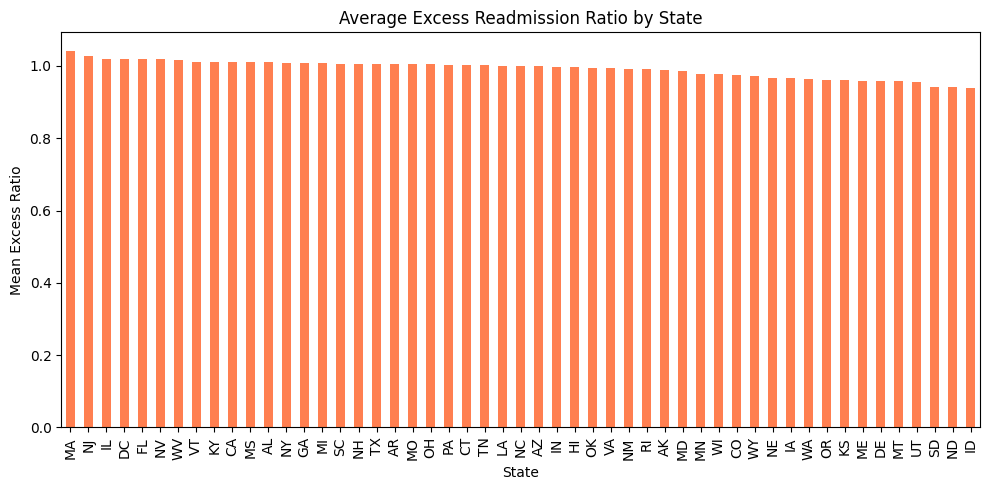

In [30]:
plt.figure(figsize=(10,5))
avg_ratio_by_state.plot(kind='bar', color='coral')
plt.title("Average Excess Readmission Ratio by State")
plt.ylabel("Mean Excess Ratio")
plt.xlabel("State")
plt.tight_layout()
plt.show()


In [31]:
import plotly.express as px

fig = px.choropleth(
    avg_ratio_by_state.reset_index(),
    locations='State',
    locationmode='USA-states',
    color='Excess Readmission Ratio',
    color_continuous_scale='Reds',
    range_color=(0.95, 1.05),
    scope="usa",
    title="Average Hospital Excess Readmission Ratio by State"
)
fig.show()


In [10]:
# Average ratio by state and condition
state_condition = (
    df.groupby(["State", "Measure Name"])["Excess Readmission Ratio"]
    .mean()
    .reset_index()
)

# Focus only on the top 5 worst states you found
worst_states = ["MA", "NJ", "IL", "DC", "FL"]
subset = state_condition[state_condition["State"].isin(worst_states)]

fig = px.bar(
    subset,
    x="State",
    y="Excess Readmission Ratio",
    color="Measure Name",
    barmode="group",
    title="Top 5 States: Excess Readmission Ratio by Condition"
)
fig.show()


In [12]:
whos


Variable   Type         Data/Info
---------------------------------
df         DataFrame    Shape: (18510, 12)
df_clean   DataFrame    Shape: (8121, 11)
np         module       Shape: <function shape at 0x71af8898e7a0>
pd         module       <module 'pandas' from '/h<...>ages/pandas/__init__.py'>
